# Cooks Distance

See more at [Cook's Distance](https://en.wikipedia.org/wiki/Cook%27s_distance). A very good description of influence and leverage can be found at [Linear Regression in Python, Outliers / Leverage Detect](https://songhuiming.github.io/pages/2016/11/27/linear-regression-in-python-outliers-leverage-detect/) (this post should make it into the Yellowbrick documentation in some form). 

A good description of outlier detection that also includes Cook's Distance is [How to Make Your Machine Learning Models Robust to Outliers](https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07). Original motivating post is at [How do you check the quality of your regression model in Python?](https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685) - source code for this post is at [
Visual analytics and diagnostics of model fit for linear regression](https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Regression/Regression_Diagnostics.ipynb).

The statsmodels source code for Cook's Distance is at:

- [Outliers Influence](http://www.statsmodels.org/0.6.1/_modules/statsmodels/stats/outliers_influence.html)
- [Linear Model](https://www.statsmodels.org/dev/_modules/statsmodels/regression/linear_model.html)
- [NumPy Linear Algebra](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html)

In [1]:
%matplotlib notebook

import scipy as sp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

# Note: statsmodels requires scipy 1.2
import statsmodels.formula.api as sm

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import OLSInfluence as influence

from yellowbrick.base import Visualizer

## Random Test Data

For the purpose of generating tests for the visualizer, I'm using random test data. The compressive concrete strength dataset would also be good for integration testing.

In [2]:
# Make Test Dataset
X, y = make_regression(
    n_samples=100, n_features=14, n_informative=6, bias=1.2, noise=49.8, tail_strength=0.6, random_state=637
)

# Convert to a DataFrame for statsmodels
data = pd.DataFrame(X)
data.columns = [f"X{i}" for i in range(X.shape[1])]
data["y"] = y
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,y
0,-0.079099,0.774174,-0.389897,-1.009309,-0.082365,0.637309,0.236902,1.618119,-0.520738,-0.210891,0.654572,-0.366485,-0.859211,0.145978,42.341339
1,-0.896311,1.928183,-0.538742,0.588117,0.724919,-0.856656,0.842047,-1.796532,-0.534544,2.421266,-0.115243,1.585129,-0.103442,0.169937,-64.162092
2,0.479350,-0.544794,-0.180732,0.899390,-0.874454,0.907707,1.058048,1.266299,0.033375,-0.241988,0.161981,-0.770880,0.785022,-2.043742,-63.616222
3,-0.793136,1.422011,-1.109729,-1.434248,1.392304,0.622966,-0.472442,0.075291,-0.077669,-1.725702,-0.075634,0.147481,-0.918953,-0.566963,-84.649787
4,0.670828,0.149658,0.116948,0.011745,-2.450315,-0.529813,-1.586794,-0.337791,-1.360943,-1.209053,-0.029231,0.909747,-0.142993,-1.622250,-166.153271


## Statsmodels Results

For comparison to the custom computation, this section computes the statsmodels OLS model and Cook's Distance values. In a later section we will compare this to scikit-learn linear regression and the Yellowbrick cooks function.

In [3]:
# Compute an OLS model 
cols = data.columns
model = sm.ols(formula=f"{cols[-1]} ~ {' + '.join(cols[:-1])}", data=data)
model = model.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     45.14
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           2.75e-33
Time:                        16:26:30   Log-Likelihood:                -513.54
No. Observations:                 100   AIC:                             1057.
Df Residuals:                      85   BIC:                             1096.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.9575      5.033     -1.978      0.0

In [4]:
# Compute the influence to get Cook's distance
inf = influence(model)

# cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
C, P = inf.cooks_distance

<IPython.core.display.Javascript object>


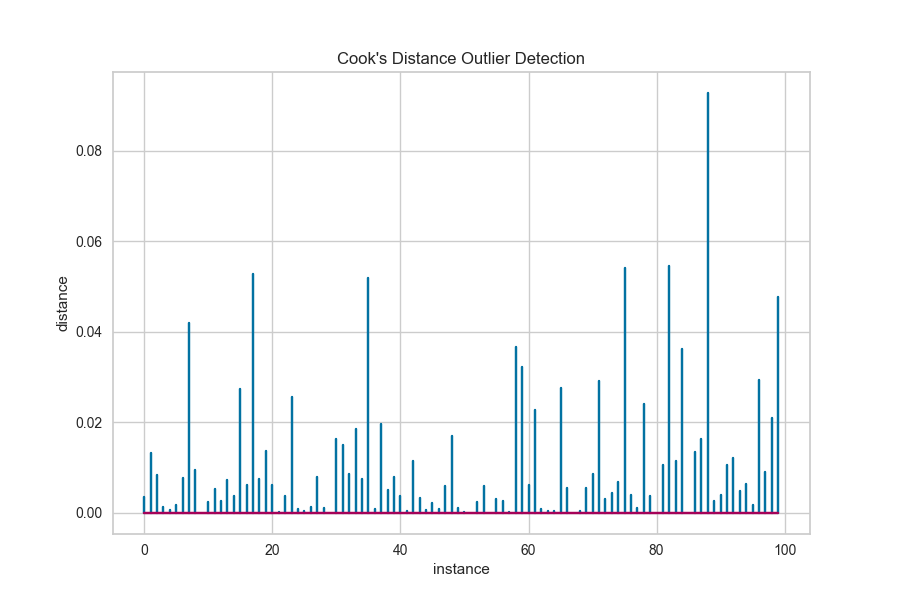

In [5]:
def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax


plot_cooks_distance(C)

## Scikit-Learn Cook's Distance

<IPython.core.display.Javascript object>


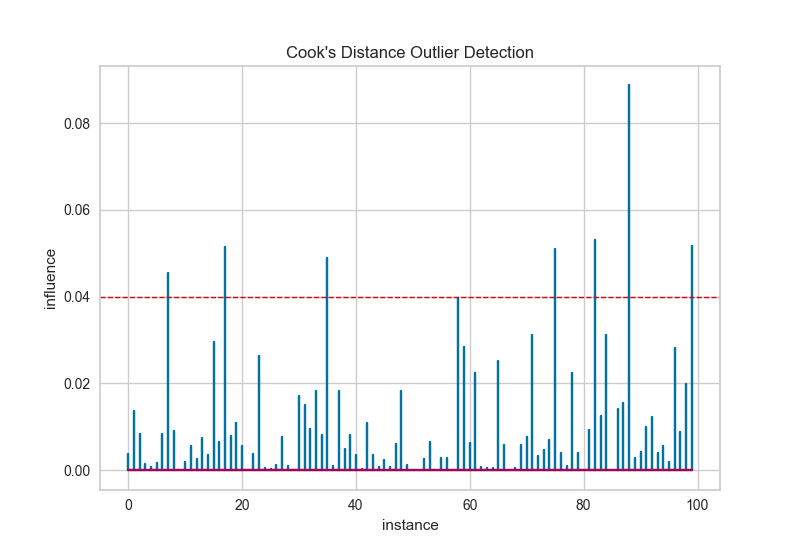

In [6]:
class CooksDistance(Visualizer):
    
    def fit(self, X, y):
        # Leverage is computed as the diagonal of the projection matrix of X 
        # TODO: whiten X before computing leverage
        self.leverage_ = (X * np.linalg.pinv(X).T).sum(1)
        
        # Compute the MSE
        rank = np.linalg.matrix_rank(X)
        df = X.shape[0] - rank
        
        resid = y - LinearRegression().fit(X, y).predict(X)
        mse = np.dot(resid, resid) / df 
        
        resid_studentized_internal = resid / np.sqrt(mse) / np.sqrt(1-self.leverage_)
        
        self.distance_ = resid_studentized_internal**2 / X.shape[1]
        self.distance_ *= self.leverage_ / (1 - self.leverage_)

        self.p_values_ = sp.stats.f.sf(self.distance_, X.shape[1], df)
        
        self.draw()
        return self
    
    
    def draw(self):
        self.ax.stem(self.distance_, markerfmt=",", label="influence")
        self.ax.axhline(4/len(self.distance_), c='r', ls='--', lw=1, label="$\frac{4}{n}$")
    
    def finalize(self):
        self.ax.legend()
        self.ax.set_xlabel("instance")
        self.ax.set_ylabel("influence")
        self.ax.set_title("Cook's Distance Outlier Detection")
    
    
viz = CooksDistance().fit(X, y)
viz.finalize()